In [6]:
import qiskit
import numpy as np, pandas as pd
%load_ext autoreload
%autoreload 2
import data, po, model, ast, csv

for num_assets in range(16,17):

    file_name = f'./result_{num_assets}.csv'
    result = pd.read_csv(file_name)
    for i in range(0, len(result)):
        asset_list = (result['assets'][i])
        array_string = asset_list.replace("[", "").replace("]", "").replace("'", "")
        asset_list = array_string.split()
        mu, sigma, _ = data.get_mu_sigma_specific('asset.csv', asset_list)
        numpy_result, qpo_result = (model.qpo(mu, sigma))
        
        file_name = f"compare_{num_assets}.csv"
        # check if file exists
        try:
            with open(file_name, 'r') as csvfile:
                pass
        except FileNotFoundError:
            with open(file_name, 'w') as csvfile:
                # Create a csv writer object
                csvwriter = csv.writer(csvfile)
                # Write the row to csv file
                csvwriter.writerow(['assets', 'numpy', 'qpo'])
        df = pd.read_csv(file_name)
        asset = df.assets.unique()
        row = [[str(asset_list),numpy_result, qpo_result]]
            
        if row[0][0] not in asset:
            with open(file_name, 'a') as csvfile:
                # Create a csv writer object
                # Check the value of first cell in row, if it is existing, then skip writing it
                
                csvwriter = csv.writer(csvfile)
                csvwriter.writerows(row)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[0 0 0 1 1 1 1 1 0 0 0 1 0 0 1 1]
[0 1 0 1 0 1 1 0 0 1 0 0 1 1 0 1]
[0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1]
[1 1 1 0 1 0 0 1 0 0 0 0 1 1 1 0]
[1 1 0 1 0 1 0 1 1 0 0 0 1 0 0 1]
[0 0 0 1 1 1 1 0 1 1 1 0 0 0 0 1]
[1 1 1 1 0 0 0 0 1 0 1 0 0 0 1 1]
[0 1 0 1 1 0 0 0 1 1 1 0 0 1 1 0]
[0 1 0 0 1 0 1 0 1 0 0 1 1 1 0 1]


/Users/vutuanhai/Documents/GitHub/quantum_finance/model.py:44: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(result.get(0, 0) - result.get(1, 0))*x_k*mu_k, abs(np.inner(x, mu))


[0 0 1 0 1 0 1 1 0 0 1 0 1 1 0 1]
[1 0 0 0 1 0 1 1 1 1 1 0 1 0 0 0]
[1 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1]
[0 1 1 1 0 0 0 1 0 0 0 1 1 0 1 1]
[0 1 0 1 0 0 0 0 1 1 1 1 1 0 1 0]
[1 1 1 0 0 0 0 1 1 0 1 0 0 1 1 0]
[0 0 1 1 1 0 1 1 0 0 0 1 0 0 1 1]
[1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 1]
[0 1 1 0 1 1 0 0 1 0 0 1 0 1 0 1]
[0 0 1 0 0 1 0 1 1 1 0 0 1 1 0 1]
[0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 1]
[0 1 1 1 0 1 0 1 0 0 1 0 0 1 0 1]
[0 0 1 0 1 1 0 1 0 0 1 1 1 0 0 1]
[0 0 1 0 0 1 1 0 1 0 1 1 0 0 1 1]
[0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1]
[1 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0]
[0 1 1 1 0 1 0 1 0 0 0 1 0 0 1 1]
[0 0 1 0 1 0 0 0 1 1 1 1 0 1 0 1]


/Users/vutuanhai/Documents/GitHub/quantum_finance/model.py:44: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(result.get(0, 0) - result.get(1, 0))*x_k*mu_k, abs(np.inner(x, mu))


[0 1 0 1 0 0 1 1 1 1 1 0 1 0 0 0]
[0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1]
[1 0 1 1 1 1 0 0 1 0 0 0 0 1 1 0]
[1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1]
[0 0 1 1 0 0 1 1 0 1 0 1 0 1 1 0]
[0 0 1 0 0 1 0 0 0 1 0 1 1 1 1 1]
[1 1 0 1 1 0 0 0 0 1 1 0 0 1 1 0]


/Users/vutuanhai/Documents/GitHub/quantum_finance/model.py:44: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(result.get(0, 0) - result.get(1, 0))*x_k*mu_k, abs(np.inner(x, mu))


[1 1 0 1 1 0 1 0 0 0 0 0 1 1 0 1]
[0 1 0 1 0 0 0 1 0 1 0 1 1 0 1 1]
[1 0 1 0 1 0 0 1 1 0 1 1 1 0 0 0]
[1 1 0 0 0 0 1 1 0 1 0 1 1 1 0 0]
[0 1 0 0 0 1 0 1 1 1 1 1 0 1 0 0]
[0 1 0 0 1 0 1 1 0 1 1 0 0 1 1 0]
[0 1 1 0 1 0 1 0 1 1 0 1 0 1 0 0]
[0 1 0 0 1 1 1 0 1 0 0 1 1 0 0 1]
[0 0 1 0 1 1 1 1 1 0 0 0 0 1 1 0]
[0 1 0 1 1 0 1 0 1 0 1 0 0 0 1 1]
[1 0 0 1 1 1 1 1 0 1 0 0 0 0 1 0]
[1 1 0 0 0 0 1 0 0 1 1 0 1 1 0 1]
[0 1 1 1 0 0 0 0 0 1 1 0 1 1 1 0]
[1 0 1 0 0 1 1 1 0 0 0 1 0 1 1 0]
[1 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0]
[0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 1]
[1 1 0 1 1 0 1 1 0 0 0 1 1 0 0 0]
[1 0 1 1 0 0 1 0 1 1 0 0 1 1 0 0]
[0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 0]
[1 1 0 1 0 1 1 0 0 0 0 0 0 1 1 1]
[1 0 1 0 0 0 1 0 0 0 1 1 1 1 0 1]
[0 0 1 0 0 1 0 1 0 1 1 1 0 1 1 0]
[0 0 1 0 1 1 1 1 0 1 0 1 1 0 0 0]
[1 0 1 0 0 0 1 0 1 0 0 1 1 1 0 1]
[0 1 1 1 0 0 1 0 0 0 1 0 0 1 1 1]
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1]
[1 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1]
[0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0]
[0 0 0 1 1 0 0 1 0 1 0 0 1 1 1 1]
[0 1 1 0 0 1 0

/Users/vutuanhai/Documents/GitHub/quantum_finance/model.py:44: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(result.get(0, 0) - result.get(1, 0))*x_k*mu_k, abs(np.inner(x, mu))


[0 0 1 1 0 0 1 0 1 0 0 1 0 1 1 1]
[0 1 1 1 0 1 1 0 1 0 1 0 1 0 0 0]
[1 1 0 0 0 0 0 0 1 0 0 1 1 1 1 1]
[0 0 1 1 0 1 1 1 1 0 1 0 0 1 0 0]
[1 1 1 0 1 1 1 0 0 0 0 0 1 1 0 0]
[0 1 1 0 1 0 0 1 1 1 0 0 1 1 0 0]
[1 0 1 0 0 1 1 1 0 0 0 0 0 1 1 1]
[0 1 1 0 1 1 0 0 1 0 0 0 1 1 1 0]
[0 1 1 0 1 1 1 1 0 0 1 0 1 0 0 0]
[0 1 0 1 0 0 1 1 1 0 1 1 0 1 0 0]


/Users/vutuanhai/Documents/GitHub/quantum_finance/model.py:44: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(result.get(0, 0) - result.get(1, 0))*x_k*mu_k, abs(np.inner(x, mu))


[1 0 0 0 1 1 0 1 0 0 1 0 1 1 0 1]
[1 1 0 1 1 0 0 0 1 0 0 1 1 0 1 0]
[1 0 1 0 0 0 1 0 1 0 1 0 0 1 1 1]
[0 1 0 0 1 0 1 0 0 1 0 1 0 1 1 1]
[1 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0]
[1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0]
[0 1 1 0 0 0 0 1 1 0 1 1 1 0 0 1]
[0 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1]
[0 0 1 1 1 0 0 0 1 1 1 1 0 0 0 1]
[1 1 0 0 1 0 0 1 1 0 1 1 0 0 1 0]
[0 0 1 0 0 0 1 1 1 1 1 0 0 1 0 1]


In [14]:
import qiskit
import numpy as np, pandas as pd
%load_ext autoreload
%autoreload 2
import data, po, model, ast, csv
import time
times = []
timesx = []
for num_assets in range(2,17):
    times = []
    file_name = f'./result/result_{num_assets}.csv'
    result = pd.read_csv(file_name)
    for i in range(0, 10):
        asset_list = (result['assets'][i])
        array_string = asset_list.replace("[", "").replace("]", "").replace("'", "")
        asset_list = array_string.split()
        mu, sigma, _ = data.get_mu_sigma_specific('asset.csv', asset_list)
        begin = time.time()
        numpy_result, qpo_result = (model.qpo(mu, sigma))
        end = time.time()
        times.append(end-begin)
    timesx.append(np.mean(times))
    print(f"Num assets {num_assets}: ", np.mean(times))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Num assets 2:  0.0078067779541015625
Num assets 3:  0.011284422874450684
Num assets 4:  0.011734461784362793
Num assets 5:  0.02232699394226074
Num assets 6:  0.02306101322174072


/Users/vutuanhai/Documents/GitHub/quantum_finance/model.py:43: RuntimeWarning: invalid value encountered in sqrt
  result = sampler.run(qc, shots = 10000).result().quasi_dists[0]
/Users/vutuanhai/Documents/GitHub/quantum_finance/model.py:43: RuntimeWarning: invalid value encountered in sqrt
  result = sampler.run(qc, shots = 10000).result().quasi_dists[0]


Num assets 7:  0.025965023040771484
Num assets 8:  0.029480600357055665


/Users/vutuanhai/Documents/GitHub/quantum_finance/model.py:43: RuntimeWarning: invalid value encountered in sqrt
  result = sampler.run(qc, shots = 10000).result().quasi_dists[0]


Num assets 9:  0.05644092559814453


/Users/vutuanhai/Documents/GitHub/quantum_finance/model.py:43: RuntimeWarning: invalid value encountered in sqrt
  result = sampler.run(qc, shots = 10000).result().quasi_dists[0]


Num assets 10:  0.06453001499176025


/Users/vutuanhai/Documents/GitHub/quantum_finance/model.py:43: RuntimeWarning: invalid value encountered in sqrt
  result = sampler.run(qc, shots = 10000).result().quasi_dists[0]


Num assets 11:  0.0654184341430664


/Users/vutuanhai/Documents/GitHub/quantum_finance/model.py:43: RuntimeWarning: invalid value encountered in sqrt
  result = sampler.run(qc, shots = 10000).result().quasi_dists[0]
/Users/vutuanhai/Documents/GitHub/quantum_finance/model.py:43: RuntimeWarning: invalid value encountered in sqrt
  result = sampler.run(qc, shots = 10000).result().quasi_dists[0]


Num assets 12:  0.08128306865692139
Num assets 13:  0.09692492485046386
Num assets 14:  0.12835533618927003


/Users/vutuanhai/Documents/GitHub/quantum_finance/model.py:43: RuntimeWarning: invalid value encountered in sqrt
  result = sampler.run(qc, shots = 10000).result().quasi_dists[0]


Num assets 15:  0.18279435634613037
Num assets 16:  0.33434467315673827


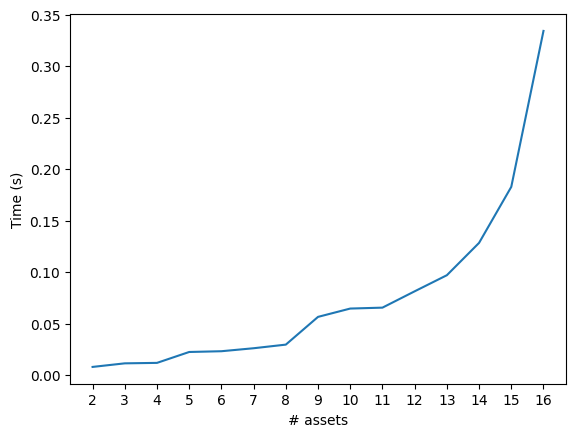

In [15]:
import matplotlib.pyplot as plt

plt.xticks(range(2,17))
plt.plot(range(2,17),timesx)
plt.ylabel('Time (s)')
plt.xlabel('# assets')
plt.show()

In [16]:
import numpy as np
import matplotlib.pyplot as plt, csv
import datetime
import data, po, model
import ast, pandas as pd
from qsee.core.ansatz import Wchain_zxz
%load_ext autoreload
%autoreload 2

times_x_qoao = []
times_x_vqe = []
for num_assets in range(2,17):
    times_vqe = []
    times_qoao = []
    for i in range(10):    
        mu, sigma, asset_list = data.get_mu_sigma('asset.csv', num_assets)
        qp = po.to_po(mu, sigma, num_assets = num_assets, q = 0.5)
        begin = time.time()
        resultQOAO = model.qoao(qp)
        end = time.time()
        times_qoao.append(end-begin)
        begin = time.time()
        resultVQE = model.vqe(qp, Wchain_zxz(num_assets, int(np.ceil(num_assets/2))))
        end = time.time()
        times_vqe.append(end-begin)
    times_x_qoao.append(np.mean(times_qoao))
    times_x_vqe.append(np.mean(times_vqe))
plt.plot(range(2,17),times_x_qoao, label = 'QOAO')
plt.plot(range(2,17),times_x_vqe, label = 'VQE')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Traceback (most recent call last):
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_cobyla_py.py", line 281, in calcfc
    f = sf.fun(x)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py", line 267, in fun
    self._update_fun()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py", line 251, in _update_fun
    self._update_fun_impl()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py", line 155, in update_fun
    self.f = fun_wrapped(self.x)
  File "/Library/Frameworks/Python.fram

: 

In [39]:
# create 8-dimensional binary vector
for i in [2,4,8,16,32,64]:
    x = np.random.randint(2, size=i)
    x = x /np.sqrt(np.sum(x))
    qc = qiskit.QuantumCircuit(int(np.log2(len(x))))
    qc.prepare_state(x)
    from qiskit.compiler import transpile
    from qiskit.providers.fake_provider import FakeQasmSimulator
    qc1 = transpile(qc, backend = FakeQasmSimulator())

    print(qc1.depth())

1
1
10
26
57
118


In [36]:



mu, sigma, _ = data.get_mu_sigma_specific('asset.csv', ['ATMUSDT','SOLUSDT','BNXUSDT', 'AAVEUSDT', 'APTUSDT'])
print(mu, sigma)

[-0.0029036236691319084, -0.0026702570589396614, -0.011380828801780924, 0.000619347729741717, -0.00527452174872208] [[0.00106326 0.00061676 0.00125094 0.00066726 0.00084313]
 [0.00061676 0.00145862 0.00140272 0.00107915 0.00136494]
 [0.00125094 0.00140272 0.00309352 0.00132747 0.00200171]
 [0.00066726 0.00107915 0.00132747 0.00203238 0.00127067]
 [0.00084313 0.00136494 0.00200171 0.00127067 0.00206379]]
